In [1]:
# -------------------------
# Optional installs (uncomment if needed)
# -------------------------
!pip install torch==2.1.2 torchvision==0.16.2
!pip install transformers==4.36.2 pandas numpy scikit-learn pillow tqdm seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.1.2-cp39-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached torchvision-0.16.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.6 kB)
Using cached torch-2.1.2-cp39-none-macosx_11_0_arm64.whl (59.6 MB)
Using cached torchvision-0.16.2-cp39-cp39-macosx_11_0_arm64.whl (1.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0
    Uninstalling torchvision-0.16.0:
      Successfully uninstalled torchvision-0.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0 requires torch==2.1.0, but you have torch 2.1.2 which is incompatible.

[notice] A new release of pip is av

Using device: mps
Loading test annotations...
Building ViT and loading weights...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([26]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([26, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded weights from best_vit_emotic.pth
Loaded thresholds from vit_dynamic_thresholds.npy with shape (26,)


Testing ViT: 100%|██████████| 228/228 [03:17<00:00,  1.15it/s]



VIT EVALUATION RESULTS (TEST)
Mean Average Precision (mAP): 0.1759
C-F1 (Label-based F1):       0.2496
O-F1 (Example-based F1):     0.2899

Detailed Per-Category Metrics:
      Emotion  ViT_AP  ViT_F1
    Affection  0.1597  0.2527
        Anger  0.1580  0.2349
    Annoyance  0.1386  0.2420
 Anticipation  0.4720  0.6351
     Aversion  0.7853  0.8695
   Confidence  0.5171  0.6427
  Disapproval  0.5048  0.6307
Disconnection  0.3163  0.4491
 Disquietment  0.5134  0.6445
        Doubt  0.0653  0.1158
Embarrassment  0.0889  0.1558
   Engagement  0.1336  0.2534
       Esteem  0.1345  0.2656
   Excitement  0.0567  0.1118
      Fatigue  0.0167  0.0365
         Fear  0.0625  0.1211
    Happiness  0.0461  0.0866
         Pain  0.0315  0.0586
        Peace  0.0407  0.0899
     Pleasure  0.0247  0.0446
      Sadness  0.0333  0.0567
  Sensitivity  0.0549  0.1020
    Suffering  0.1241  0.2207
     Surprise  0.0343  0.0627
     Sympathy  0.0233  0.0393
     Yearning  0.0361  0.0670

Saved: per_catego

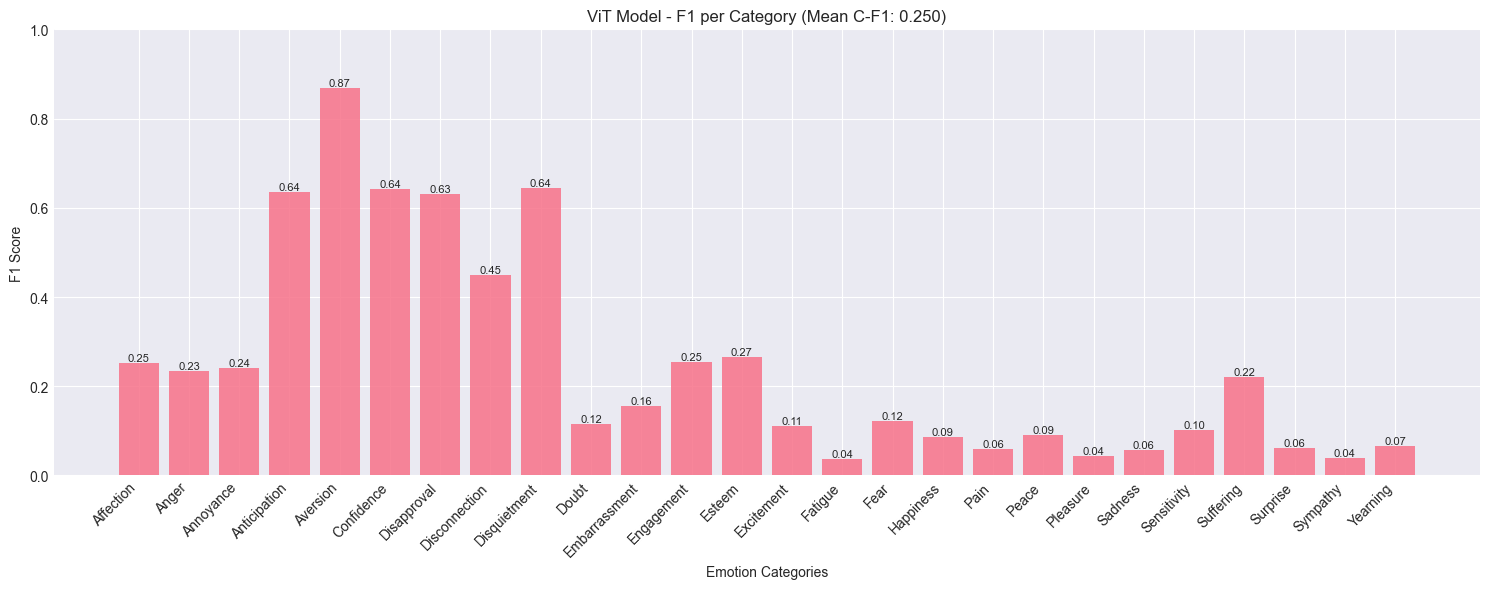

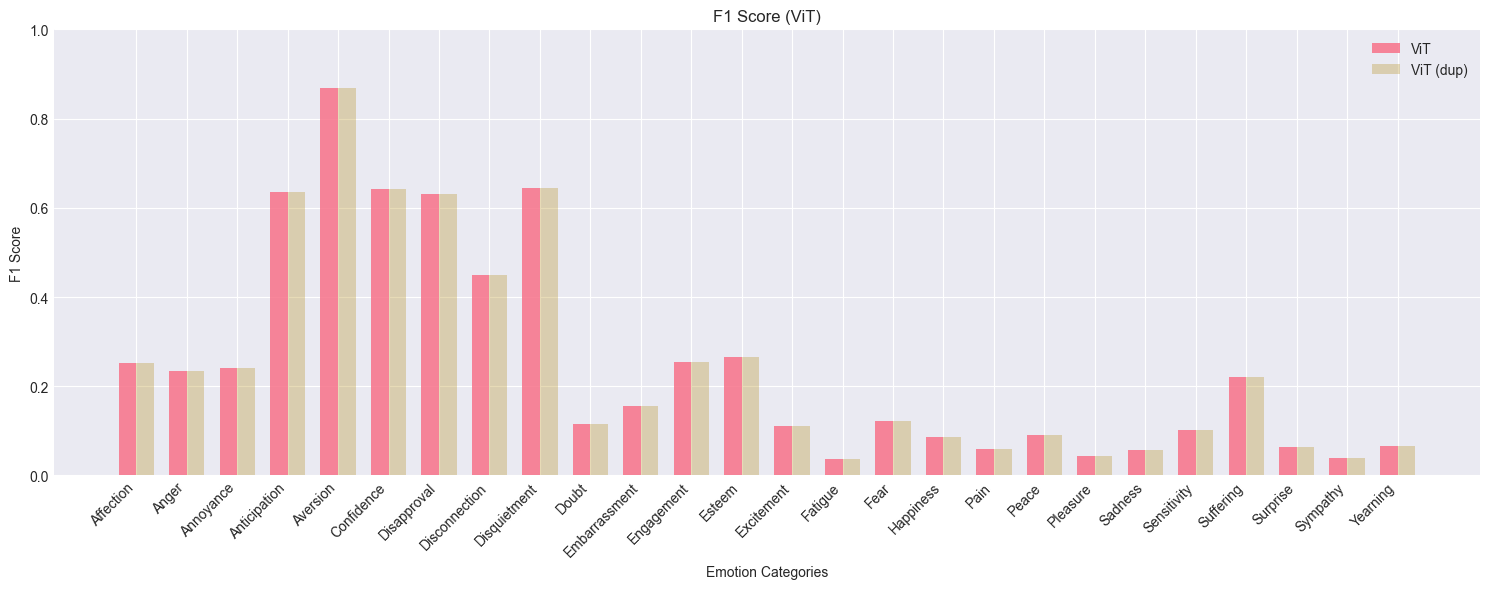

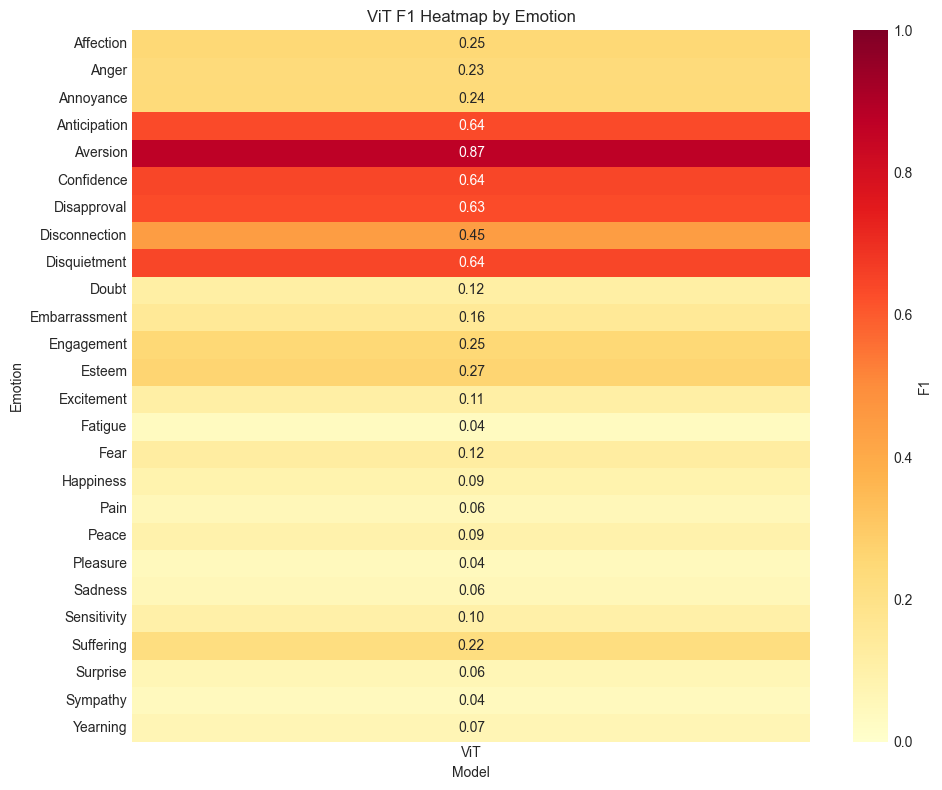


Top 5 ViT categories by F1:
  Aversion: 0.8695
  Disquietment: 0.6445
  Confidence: 0.6427
  Anticipation: 0.6351
  Disapproval: 0.6307

Bottom 5 ViT categories by F1:
  Fatigue: 0.0365
  Sympathy: 0.0393
  Pleasure: 0.0446
  Sadness: 0.0567
  Pain: 0.0586


In [2]:
"""
ViT EMOTIC Testing and Evaluation

Directory layout expected (from your training notebook):
- archive/annots_arrs/annot_arrs_train.csv
- archive/annots_arrs/annot_arrs_val.csv
- archive/annots_arrs/annot_arrs_test.csv
- archive/img_arrs/*.npy                      # RGB or grayscale arrays
Outputs from training used here:
- best_vit_emotic.pth                         # model weights

Optional:
- vit_dynamic_thresholds.npy                  # dynamic thresholds; if absent we compute from val, else 0.5
"""

# -------------------------
# Optional installs (uncomment if needed)
# -------------------------
# !pip install torch==2.1.2 torchvision==0.16.2
# !pip install transformers==4.36.2 pandas numpy scikit-learn pillow tqdm seaborn matplotlib

# -------------------------
# Imports & setup
# -------------------------
import os, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import average_precision_score, f1_score, precision_recall_fscore_support

from transformers import AutoImageProcessor, ViTForImageClassification

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# -------------------------
# Device (MPS → CUDA → CPU)
# -------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# -------------------------
# Constants
# -------------------------
EMOTION_CATEGORIES = [
    'Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
    'Confidence', 'Disapproval', 'Disconnection', 'Disquietment', 'Doubt',
    'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue',
    'Fear', 'Happiness', 'Pain', 'Peace', 'Pleasure',
    'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy',
    'Yearning'
]
NUM_CLASSES = 26

# -------------------------
# Annotations (matches your ViT notebook)
#   - Uses CSV column slice df.columns[8:34] as the 26 label columns
#   - Uses 'Crop_name' for the .npy file name
# -------------------------
def parse_annotations(csv_path, num_categories=NUM_CLASSES):
    df = pd.read_csv(csv_path)
    category_columns = df.columns[8:8+num_categories]  # 8..33 inclusive → 26 cols

    annotations = []
    for _, row in df.iterrows():
        cats = [int(i) for i, v in enumerate(row[category_columns]) if v == 1]
        annotations.append({"filename": row["Crop_name"], "categories": cats})
    return annotations

# -------------------------
# Dataset for ViT
#   - Loads .npy → PIL → AutoImageProcessor
#   - Returns (pixel_values_tensor, labels_tensor)
# -------------------------
class EMOTICViTDataset(Dataset):
    def __init__(self, annotations, img_dir, image_processor: AutoImageProcessor, num_categories=NUM_CLASSES):
        self.annotations = annotations
        self.img_dir = img_dir
        self.processor = image_processor
        self.num_categories = num_categories

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        entry = self.annotations[idx]
        img_path = os.path.join(self.img_dir, entry['filename'])
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing image: {img_path}")

        arr = np.load(img_path)
        # Ensure RGB
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        elif arr.shape[-1] != 3:
            raise ValueError(f"Unexpected image shape {arr.shape} for {img_path}")

        # Convert to PIL (uint8 if needed)
        if arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        pil = Image.fromarray(arr)

        inputs = self.processor(images=pil, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3,224,224)

        labels = torch.zeros(self.num_categories, dtype=torch.float32)
        for c in entry['categories']:
            if 0 <= c < self.num_categories:
                labels[c] = 1.0

        return pixel_values, labels

# -------------------------
# Build ViT model same way as training
# - Base: google/vit-base-patch16-224
# - Multi-label, custom head: Dropout(0.3) + Linear(hidden_size→26)
# -------------------------
def build_vit_model(num_classes=NUM_CLASSES):
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224",
        num_labels=num_classes,
        problem_type="multi_label_classification",
        ignore_mismatched_sizes=True,
    )
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.config.hidden_size, num_classes)
    )
    return model

# -------------------------
# Metrics
# -------------------------
def calculate_average_precision(y_true, y_scores):
    ap = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0:
            ap.append(average_precision_score(y_true[:, i], y_scores[:, i]))
        else:
            ap.append(0.0)
    return np.array(ap)

def calculate_label_based_f1(y_true, y_pred):
    f1s = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0 or y_pred[:, i].sum() > 0:
            f1s.append(f1_score(y_true[:, i], y_pred[:, i], average="binary", zero_division=0))
        else:
            f1s.append(0.0)
    return np.array(f1s)

def calculate_example_based_f1(y_true, y_pred):
    f1s = []
    for i in range(len(y_true)):
        if y_true[i].sum() > 0 or y_pred[i].sum() > 0:
            f1s.append(f1_score(y_true[i], y_pred[i], average="binary", zero_division=0))
        else:
            f1s.append(0.0)
    return float(np.mean(f1s))

# -------------------------
# Thresholding
# - If vit_dynamic_thresholds.npy exists → load
# - Else if val CSV provided → compute per-class best F1 thresholds on val
# - Else → use 0.5
# -------------------------
def compute_dynamic_thresholds(model, loader):
    model.eval()
    all_t, all_p = [], []
    with torch.no_grad():
        for px, labels in loader:
            px = px.to(device)
            labels = labels.to(device)
            logits = model(px).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            all_t.append(labels.cpu().numpy())
            all_p.append(probs)
    all_t = np.vstack(all_t)
    all_p = np.vstack(all_p)

    thresholds = []
    grid = np.linspace(0.05, 0.95, 19)
    for i in range(all_p.shape[1]):
        best_f1, best_th = -1.0, 0.5
        for th in grid:
            preds = (all_p[:, i] > th).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(all_t[:, i], preds, average="binary", zero_division=0)
            if f1 > best_f1:
                best_f1, best_th = f1, th
        thresholds.append(best_th)
    return np.array(thresholds, dtype=np.float32)

# -------------------------
# Evaluation loop
# -------------------------
def evaluate_model(model, loader, thresholds):
    model.eval()
    all_t, all_s = [], []
    with torch.no_grad():
        for px, labels in tqdm(loader, desc="Testing ViT"):
            px = px.to(device)
            logits = model(px).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            all_t.append(labels.numpy())
            all_s.append(probs)
    all_t = np.vstack(all_t)
    all_s = np.vstack(all_s)

    # binarize with thresholds
    preds = (all_s > thresholds.reshape(1, -1)).astype(int)

    # metrics
    ap = calculate_average_precision(all_t, all_s)
    mAP = float(np.mean(ap[ap > 0])) if np.any(ap > 0) else 0.0
    c_f1_per = calculate_label_based_f1(all_t, preds)
    c_f1_mean = float(np.mean(c_f1_per[c_f1_per > 0])) if np.any(c_f1_per > 0) else 0.0
    o_f1 = calculate_example_based_f1(all_t, preds)

    return {
        "ap_per_category": ap,
        "mAP": mAP,
        "c_f1_per_category": c_f1_per,
        "c_f1_mean": c_f1_mean,
        "o_f1": o_f1,
        "predictions": preds,
        "targets": all_t,
        "scores": all_s,
    }

# -------------------------
# Visualization
# -------------------------
def plot_f1_scores(results, emotion_categories):
    # single-model bar + side-by-side self-compare (same data duplicated for layout symmetry)
    fig, ax = plt.subplots(figsize=(15, 6))
    x = np.arange(len(emotion_categories))
    bars = ax.bar(x, results['c_f1_per_category'], alpha=0.85)
    ax.set_xlabel('Emotion Categories'); ax.set_ylabel('F1 Score'); ax.set_ylim([0,1])
    ax.set_title(f'ViT Model - F1 per Category (Mean C-F1: {results["c_f1_mean"]:.3f})')
    ax.set_xticks(x); ax.set_xticklabels(emotion_categories, rotation=45, ha='right')
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax.text(b.get_x() + b.get_width()/2., h, f'{h:.2f}', ha='center', va='bottom', fontsize=8)
    plt.tight_layout(); plt.savefig('vit_f1_scores_comparison.png', dpi=300, bbox_inches='tight'); plt.show()

    fig, ax = plt.subplots(figsize=(15, 6))
    width = 0.35
    ax.bar(x - width/2, results['c_f1_per_category'], width, label='ViT', alpha=0.85)
    ax.bar(x + width/2, results['c_f1_per_category'], width, label='ViT (dup)', alpha=0.35)
    ax.legend(); ax.set_ylim([0,1]); ax.set_xlabel('Emotion Categories'); ax.set_ylabel('F1 Score')
    ax.set_title('F1 Score (ViT)'); ax.set_xticks(x); ax.set_xticklabels(emotion_categories, rotation=45, ha='right')
    plt.tight_layout(); plt.savefig('vit_f1_scores_direct_comparison.png', dpi=300, bbox_inches='tight'); plt.show()

def plot_heatmap(results, emotion_categories):
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame({'ViT': results['c_f1_per_category']}, index=emotion_categories)
    sns.heatmap(df, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=1, cbar_kws={'label':'F1'})
    ax.set_title('ViT F1 Heatmap by Emotion'); ax.set_xlabel('Model'); ax.set_ylabel('Emotion')
    plt.tight_layout(); plt.savefig('vit_f1_scores_heatmap.png', dpi=300, bbox_inches='tight'); plt.show()

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    # Paths (match your training notebook layout)
    test_annotations_path = "archive/annots_arrs/annot_arrs_test.csv"
    # val_annotations_path  = "archive/annots_arrs/annot_arrs_val.csv"  # used only if thresholds file is missing
    img_dir = "archive/img_arrs"
    vit_model_path = "best_vit_emotic.pth"
    thresholds_path = "vit_dynamic_thresholds.npy"  

    batch_size = 32

    # Processor
    feature_extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)

    # Data: test
    print("Loading test annotations...")
    test_ann = parse_annotations(test_annotations_path, num_categories=NUM_CLASSES)
    test_ds = EMOTICViTDataset(test_ann, img_dir=img_dir, image_processor=feature_extractor, num_categories=NUM_CLASSES)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Build/load model
    print("Building ViT and loading weights...")
    model = build_vit_model(num_classes=NUM_CLASSES).to(device)
    state = torch.load(vit_model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    print("Loaded weights from", vit_model_path)

    # Thresholds
    if os.path.exists(thresholds_path):
        thresholds = np.load(thresholds_path)
        print(f"Loaded thresholds from {thresholds_path} with shape {thresholds.shape}")
    else:
        if os.path.exists(val_annotations_path):
            print("Threshold file not found. Computing dynamic thresholds on validation set...")
            val_ann = parse_annotations(val_annotations_path, num_categories=NUM_CLASSES)
            val_ds = EMOTICViTDataset(val_ann, img_dir=img_dir, image_processor=feature_extractor, num_categories=NUM_CLASSES)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
            thresholds = compute_dynamic_thresholds(model, val_loader)
            np.save(thresholds_path, thresholds)
            print(f"Saved thresholds to {thresholds_path}")
        else:
            print("No thresholds file or val CSV—using 0.5 for all classes.")
            thresholds = np.full((NUM_CLASSES,), 0.5, dtype=np.float32)

    # Evaluate
    vit_results = evaluate_model(model, test_loader, thresholds)

    # Print summary
    print("\n" + "="*80)
    print("VIT EVALUATION RESULTS (TEST)")
    print("="*80)
    print(f"Mean Average Precision (mAP): {vit_results['mAP']:.4f}")
    print(f"C-F1 (Label-based F1):       {vit_results['c_f1_mean']:.4f}")
    print(f"O-F1 (Example-based F1):     {vit_results['o_f1']:.4f}")

    # Per-category table
    results_df = pd.DataFrame({
        'Emotion': EMOTION_CATEGORIES,
        'ViT_AP': vit_results['ap_per_category'],
        'ViT_F1': vit_results['c_f1_per_category'],
    }).round(4)

    print("\nDetailed Per-Category Metrics:")
    print(results_df.to_string(index=False))
    results_df.to_csv('per_category_results_vit.csv', index=False)
    print("\nSaved: per_category_results_vit.csv")

    # Visuals
    print("\nGenerating visualizations...")
    plot_f1_scores(vit_results, EMOTION_CATEGORIES)
    plot_heatmap(vit_results, EMOTION_CATEGORIES)

    # Quick “best/worst” change within ViT itself (not vs another model)
    top5 = results_df.nlargest(5, 'ViT_F1')[['Emotion', 'ViT_F1']]
    bottom5 = results_df.nsmallest(5, 'ViT_F1')[['Emotion', 'ViT_F1']]
    print("\nTop 5 ViT categories by F1:")
    for _, r in top5.iterrows():
        print(f"  {r['Emotion']}: {r['ViT_F1']:.4f}")
    print("\nBottom 5 ViT categories by F1:")
    for _, r in bottom5.iterrows():
        print(f"  {r['Emotion']}: {r['ViT_F1']:.4f}")
